In [96]:
import polars as pl
from openai import OpenAI
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA





In [95]:
# 1. Setup
client = OpenAI(api_key="<API KEY>")
df = pl.scan_csv('../../data/clean/rotten_tomatoes_movie_details_clean.csv').collect()


In [19]:

# 2. Define Batching Function
def get_embeddings_batched(text_list, model="text-embedding-3-small", batch_size=2000):
    all_embeddings = []
    
    # Loop through data in chunks of 'batch_size'
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i : i + batch_size]
        
        try:
            # API Call
            response = client.embeddings.create(input=batch, model=model)
            # Extract just the vectors
            batch_embeddings = [item.embedding for item in response.data]
            all_embeddings.extend(batch_embeddings)
            print(f"Processed batch {i} to {i + len(batch)}")
            
        except Exception as e:
            print(f"Error at index {i}: {e}")
            # Optional: simple retry logic or break could go here
            break
            
    return all_embeddings

In [ ]:

# 1. Clean the FULL dataset first (Crucial!)
# We apply the same logic as the test: handle nulls and empty strings
print(f"Cleaning {df.height} movies...")

df_full_clean = df.with_columns(
    pl.when(pl.col("description").str.strip_chars().str.len_chars() == 0)
    .then(pl.lit("No description"))
    .otherwise(pl.col("description"))
    .fill_null("No description")
    .alias("description")
)

# 2. Prepare the list of texts
full_texts = df_full_clean["description"].to_list()
print(f"Ready to send {len(full_texts)} movies to OpenAI.")

# 3. Run the Embedding Function
# We use a batch size of 2000. This is safe and fast.
# Make sure your 'get_embeddings_batched' function is defined in a previous cell!
start_time = time.time()
full_vectors = get_embeddings_batched(full_texts, batch_size=2000)
end_time = time.time()

# 4. Check if we got everything
if len(full_vectors) == len(full_texts):
    print(f"Success! Generated {len(full_vectors)} vectors in {round(end_time - start_time, 2)} seconds.")
    
    # 5. SAVE IMMEDIATELY
    # We attach the vectors to the clean dataframe
    df_final = df_full_clean.with_columns(
        pl.Series(name="embedding", values=full_vectors)
    )
    
    # Write to Parquet (Safe storage)
    df_final.write_parquet("rotten_tomatoes_embedded.parquet")
    print("SAVED! File: 'rotten_tomatoes_embedded.parquet'")
    
else:
    print(f"Warning: Data mismatch. Sent {len(full_texts)} but got {len(full_vectors)} vectors.")

Cleaning 17661 movies...
Ready to send 17661 movies to OpenAI.
Processed batch 0 to 2000
Processed batch 2000 to 4000
Processed batch 4000 to 6000
Processed batch 6000 to 8000
Processed batch 8000 to 10000
Processed batch 10000 to 12000
Processed batch 12000 to 14000
Processed batch 14000 to 16000
Processed batch 16000 to 17661
Success! Generated 17661 vectors in 48.51 seconds.
SAVED! File: 'rotten_tomatoes_embedded.parquet'


In [92]:
df

rotten_tomatoes_link,title,description,release_year,embedding
str,str,str,i64,list[f64]
"""m/1074467-in_love_and_war""","""In Love and War""","""In 1918, 18-year-old Ernest He…",1996,"[-0.045627, 0.041834, … -0.002253]"
"""m/flipped""","""Flipped""","""When they meet in second grade…",2010,"[-0.024885, -0.018686, … -0.002076]"
"""m/dark_crimes""","""Dark Crimes""","""A hard-boiled detective become…",2018,"[-0.010771, -0.00484, … -0.022413]"
"""m/blackway""","""Go With Me""","""A vengeful young woman recruit…",2016,"[0.003664, 0.047893, … -0.027877]"
"""m/1014804-neighbors""","""Neighbors""","""Earl Keese (John Belushi) live…",1981,"[-0.003444, 0.059283, … -0.03641]"
…,…,…,…,…
"""m/bronson""","""Bronson""","""In this drama based on a true …",2009,"[-0.018718, 0.045026, … 0.02371]"
"""m/sausage_party""","""Sausage Party""","""Life is good for all the food …",2016,"[-0.008627, 0.038652, … -0.006783]"
"""m/bad_lieutenant_port_of_call_…","""Bad Lieutenant: Port of Call N…","""Terence McDonagh (Nicolas Cage…",2009,"[-0.010807, 0.065879, … -0.00764]"


Calculating Davies-Bouldin Index (Lower is better)...
k=2 | DBI: 6.7908
k=3 | DBI: 5.8785
k=4 | DBI: 5.5870
k=5 | DBI: 5.6121
k=6 | DBI: 5.6231
k=7 | DBI: 5.5730
k=8 | DBI: 5.4245
k=9 | DBI: 4.9503
k=10 | DBI: 5.0685
k=11 | DBI: 4.9118
k=12 | DBI: 4.9932
k=13 | DBI: 5.1673
k=14 | DBI: 4.9964
k=15 | DBI: 5.1519
k=16 | DBI: 5.0979
k=17 | DBI: 5.0946
k=18 | DBI: 4.9529
k=19 | DBI: 5.1332
k=20 | DBI: 4.9089


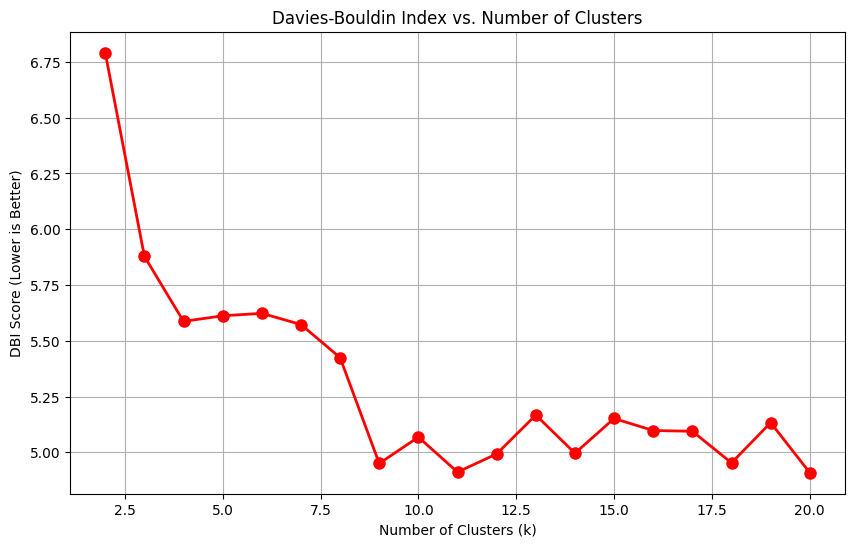

The optimal number of clusters according to DBI is: 20


In [ ]:

# Range of clusters to try
k_range = range(2, 21)
db_scores = []

print("Calculating Davies-Bouldin Index (Lower is better)...")

for k in k_range:
    # 1. Train KMeans
    # n_init=3 makes it faster for this search phase
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)
    labels = kmeans.fit_predict(matrix)
    
    # 2. Calculate DBI
    score = davies_bouldin_score(matrix, labels)
    db_scores.append(score)
    
    print(f"k={k} | DBI: {score:.4f}")

# 3. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, db_scores, 'r-o', linewidth=2, markersize=8)
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DBI Score (Lower is Better)')
plt.grid(True)
plt.show()

# 4. Find the best one programmatically
best_k = k_range[db_scores.index(min(db_scores))]
print(f"The optimal number of clusters according to DBI is: {best_k}")

In [93]:
# Run K-Means
k = 9
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(matrix)

# Add cluster IDs to DataFrame
df = df.with_columns(pl.Series(name="cluster", values=clusters))

# Inspect clusters by sampling 10 random movies from each
print(f"--- Sample Movies from {k} Clusters ---")

for i in range(k):
    print(f"\nCluster {i}:")
    sample = df.filter(pl.col("cluster") == i).sample(10)
    
    for title in sample["title"]:
        print(f"  • {title}")

--- Sample Movies from 9 Clusters ---

Cluster 0:
  • England Is Mine
  • Rebel in the Rye
  • The World's Fastest Indian
  • Altina
  • Untouchable
  • Love Hunter
  • Wal-Mart: The High Cost of Low Price
  • Bright Lights: Starring Carrie Fisher and Debbie Reynolds
  • Harold and Lillian: A Hollywood Love Story
  • Streetlight Harmonies

Cluster 1:
  • The Lonely Island Presents: The Unauthorized Bash Brothers Experience
  • Enter the Anime
  • Sacred Stage - The Mariinsky Theater
  • Belzebuth
  • The Sentence
  • Demons 2: The Nightmare Returns
  • Pay 2 Play: Democracy's High Stakes
  • Here and Now (Blue Night)
  • QA special Event 02
  • John Leguizamo's Latin History For Morons

Cluster 2:
  • Swept From the Sea
  • Smiley Face
  • The Prisoner of Zenda
  • Match
  • Queen Christina
  • Far and Away
  • My Son the Fanatic
  • The Comedians
  • Damsel
  • The Girl From Monaco

Cluster 3:
  • Badland
  • Alexander the Great
  • The Stalking Moon
  • Mutiny on the Bounty
  • Consp

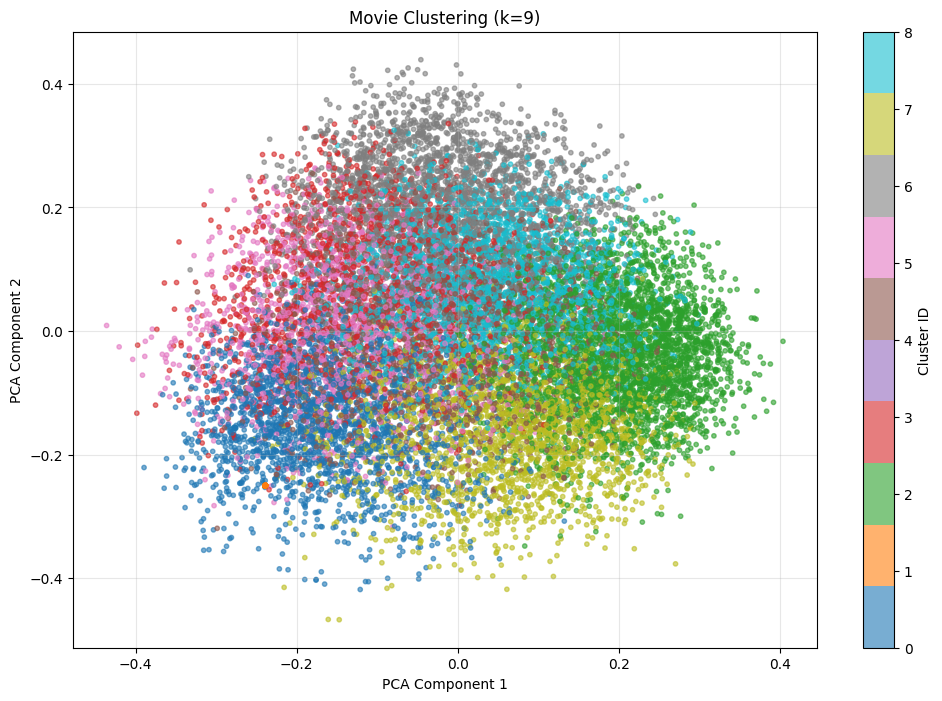

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Dimensionality Reduction
pca = PCA(n_components=2)
vis_dims = pca.fit_transform(matrix)

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(vis_dims[:, 0], vis_dims[:, 1], 
                      c=clusters, cmap='tab10', s=10, alpha=0.6)

plt.colorbar(scatter, label="Cluster ID")
plt.title(f"Movie Clustering (k={k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(alpha=0.3)
plt.show()

In [112]:

# 1. Load Data
df = pl.read_parquet("rotten_tomatoes_embedded.parquet")
all_vectors = np.stack(df["embedding"].to_numpy())

# 2. Define Lists
list_1 = [
    "The Matrix", "Alien", "Blade Runner", "The Dark Knight", "Gladiator",
    "Toy Story", "Shrek", "The Lion King", "Titanic", "Solo: A Star Wars Story"
]
list_2 = [
    "The Notebook", "Pride and Prejudice", "La La Land", "Crazy Rich Asians", 
    "Pretty Woman", "Notting Hill", "Love Actually", "The Fault in Our Stars", 
    "A Star Is Born", "Me Before You"
]
list_3 = [
    "The Conjuring", "The Exorcist", "Insidious", "Get Out", 
    "Paranormal Activity", "It Follows", "The Witch", "Hereditary", 
    "A Quiet Place", "Saw"
]
list_4 = [
    "Pulp Fiction", "Fight Club", "The Godfather", "Taxi Driver", 
    "There Will Be Blood", "Moonlight", "Lady Bird", 
    "Eternal Sunshine of the Spotless Mind", "Her", "Whiplash"
]
list_5 = [
    "Frozen", "Moana", "Finding Nemo", "Despicable Me", "Paddington 2", 
    "How to Train Your Dragon", "Zootopia", "Inside Out", "Coco", "The Incredibles"
]

# 3. Define Themes for printing
themes = [
    "Epic/Blockbuster",
    "Romantic / Love Stories",
    "Horror / Thriller",
    "Film Buff / Indie Drama",
    "Kids / Family"
]

all_lists = [list_1, list_2, list_3, list_4, list_5]

# 4. Loop
for i, history in enumerate(all_lists):
    theme_name = themes[i]
    print(f"\n--- {theme_name} ---")
    
    # Get vectors
    history_df = df.filter(pl.col("title").is_in(history))
    if history_df.height == 0: continue

    # Calculate Mean
    user_vector = np.stack(history_df["embedding"].to_numpy()).mean(axis=0).reshape(1, -1)
    
    # Search
    scores = cosine_similarity(user_vector, all_vectors).flatten()
    sorted_idx = scores.argsort()[::-1]
    
    # Print Top 5
    seen = set(history)
    count = 0
    for idx in sorted_idx:
        title = df["title"][int(idx)]
        if title not in seen:
            print(f"{scores[idx]:.4f} | {title}")
            count += 1
            if count >= 5: break


--- Epic/Blockbuster ---
0.6101 | Blade Runner: The Final Cut
0.5959 | Star Wars: The Force Awakens
0.5882 | Star Wars: Episode VI - Return of the Jedi
0.5852 | Regarding Henry
0.5807 | In the Name of the King: A Dungeon Siege Tale

--- Romantic / Love Stories ---
0.6744 | Playing by Heart
0.6694 | The Dish & the Spoon
0.6691 | Love the Hard Way
0.6657 | A Four Letter Word
0.6609 | Two Lovers

--- Horror / Thriller ---
0.7155 | Lovely Molly
0.7031 | Marrowbone
0.7027 | Lights Out
0.6952 | Paranormal Activity 4
0.6943 | The Conjuring 2

--- Film Buff / Indie Drama ---
0.6714 | The Salton Sea
0.6586 | Light Sleeper
0.6564 | Sin City
0.6519 | 21 Grams
0.6477 | The Informers

--- Kids / Family ---
0.6280 | The Florida Project
0.6280 | Nim's Island
0.6096 | Ice Age: Continental Drift
0.6069 | Hoodwinked Too! Hood vs. Evil
0.6040 | The Little Mermaid


In [86]:
# Load and Join Data
df_reviews = pl.read_csv("../../data/clean/rotten_tomatoes_critic_reviews_clean.csv")
df_movies = pl.read_parquet("rotten_tomatoes_embedded.parquet")

df_data = (
    df_reviews
    .filter(pl.col("review_score_numeric").is_not_null())
    .join(df_movies, on="rotten_tomatoes_link", how="inner")
)

# Global constants for efficiency
all_vectors = np.stack(df_movies["embedding"].to_numpy())
all_titles = df_movies["title"].to_list()
all_links = df_movies["rotten_tomatoes_link"].to_list()

def recommend_weighted(critic_name, top_k=30):
    history = df_data.filter(pl.col("critic_name") == critic_name)
    if history.height < 5: return

    vectors = np.stack(history["embedding"].to_numpy())
    scores = history["review_score_numeric"].to_numpy()
    
    # Scale scores (0-5) to weights (-1 to 1)
    weights = ((scores - 2.5) / 2.5).reshape(-1, 1)
    
    # Calculate Weighted User Vector (Sum of directional pulls)
    user_vector = np.sum(vectors * weights, axis=0).reshape(1, -1)
    
    # Similarity Search
    sims = cosine_similarity(user_vector, all_vectors).flatten()
    
    # Filter and Print
    seen_links = set(history["rotten_tomatoes_link"])
    top_indices = sims.argsort()[::-1]
    
    print(f"--- Weighted Recommendations for {critic_name} ---")
    count = 0
    for idx in top_indices:
        if all_links[int(idx)] not in seen_links:
            print(f"{sims[idx]:.4f} | {all_titles[idx]}")
            count += 1
            if count >= top_k: break

# Run on Top Critic
top_critic = df_reviews["critic_name"].value_counts().head(1)[0, "critic_name"]
recommend_weighted(top_critic)

--- Weighted Recommendations for Lawrence Toppman ---
0.5892 | The Piano
0.5737 | Cloud Atlas
0.5732 | The Deep End
0.5728 | Labor Day
0.5708 | The Theory of Flight
0.5706 | Infinitely Polar Bear
0.5650 | The Ballad of Jack and Rose
0.5634 | What We Did on Our Holiday
0.5631 | Feast of Love
0.5631 | A Little Princess
0.5614 | Synecdoche, New York
0.5611 | The Winter Guest
0.5603 | Atonement
0.5590 | The Nines
0.5582 | The Governess
0.5580 | Proof
0.5574 | The Painted Veil
0.5572 | You're Not You
0.5559 | The Book of Love
0.5555 | The Dish & the Spoon
0.5551 | Happy Endings
0.5530 | King of California
0.5507 | Breathe In
0.5504 | Side Effects
0.5503 | Nim's Island
0.5496 | Zathura
0.5496 | Fierce People
0.5494 | The Intended
0.5488 | Molly
0.5488 | A Rumor of Angels


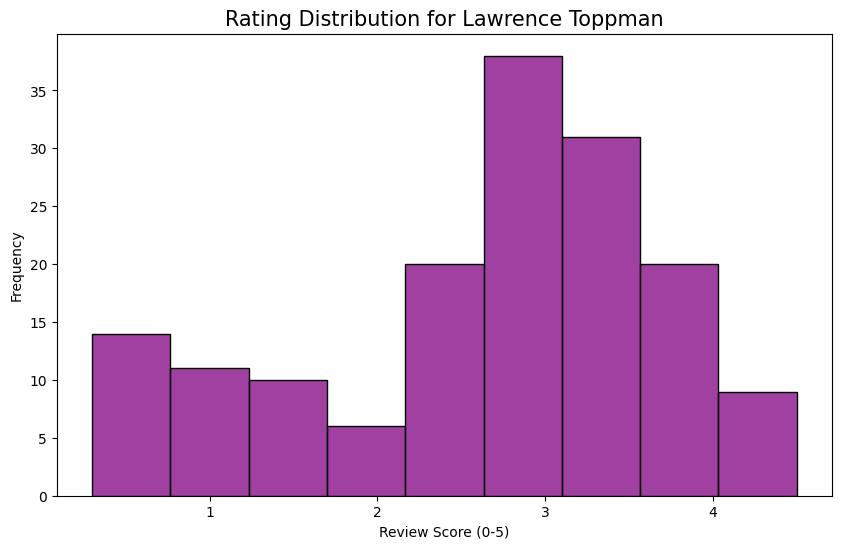

In [89]:
#show all the ratings of the top critic in a histogram
critic_history = df_data.filter(pl.col("critic_name") == top_critic)
ratings = critic_history["review_score_numeric"].to_list()  
plt.figure(figsize=(10, 6))
sns.histplot(ratings, bins=9, kde=False, color='purple', edgecolor='black')
plt.title(f'Rating Distribution for {top_critic}', fontsize=15)
plt.xlabel('Review Score (0-5)')
plt.ylabel('Frequency')
plt.show()

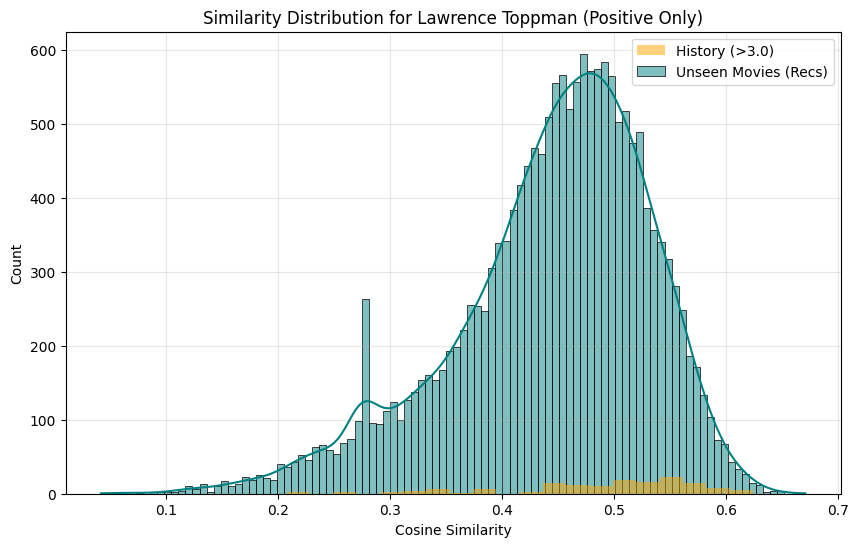

In [ ]:

def plot_critic_distribution(critic_name, threshold=3.0):
    # Filter for positive reviews only
    history = df_data.filter(
        (pl.col("critic_name") == critic_name) & 
        (pl.col("review_score_numeric") > threshold)
    )
    
    # Calculate User Vector (Simple Mean of Favorites)
    user_vector = np.stack(history["embedding"].to_numpy()).mean(axis=0).reshape(1, -1)
    
    # Get all similarities
    sims = cosine_similarity(user_vector, all_vectors).flatten()
    
    # Separate Seen (History) vs Unseen (Recommendations)
    seen_links = set(df_data.filter(pl.col("critic_name") == critic_name)["rotten_tomatoes_link"])
    mask = [link not in seen_links for link in all_links]
    
    unseen_scores = sims[mask]
    seen_scores = sims[~np.array(mask)]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.histplot(unseen_scores, bins=100, kde=True, color='teal', label='Unseen Movies (Recs)')
    plt.hist(seen_scores, bins=20, color='orange', alpha=0.5, label='History (>3.0)')
    
    plt.title(f'Similarity Distribution for {critic_name} (Positive Only)')
    plt.xlabel('Cosine Similarity')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_critic_distribution(top_critic)

C:\Users\farim\AppData\Local\Temp\ipykernel_21160\1448022770.py:6: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  df_data.group_by("critic_name").count()


Validating on 345 critics (Random Split)...
Global Average Correlation: -0.0451


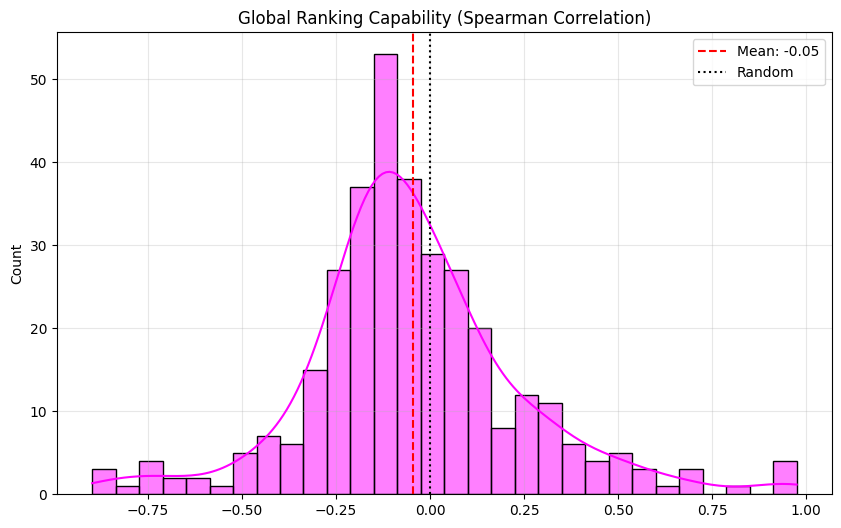

In [ ]:
from scipy.stats import spearmanr

def validate_spearman(min_reviews=20, split_ratio=0.8, seed=42):
    # Filter valid critics
    valid_critics = (
        df_data.group_by("critic_name").count()
        .filter(pl.col("count") >= min_reviews)
        .select("critic_name").to_series().to_list()
    )
    
    print(f"Validating on {len(valid_critics)} critics (Random Split)...")
    correlations = []
    
    for critic in valid_critics:
        # Get and Shuffle History
        history = df_data.filter(pl.col("critic_name") == critic)
        history = history.sample(fraction=1.0, shuffle=True, seed=seed)
        
        # Split Train/Test
        n = history.height
        cut = int(n * split_ratio)
        train, test = history.head(cut), history.tail(n - cut)
        
        if test.height < 5: continue
            
        # Build Profile (Movies > 3.0)
        good_train = train.filter(pl.col("review_score_numeric") > 3.0)
        if good_train.height == 0: continue
            
        user_vector = np.stack(good_train["embedding"].to_numpy()).mean(axis=0).reshape(1, -1)
        
        # Predict
        test_vecs = np.stack(test["embedding"].to_numpy())
        preds = cosine_similarity(user_vector, test_vecs).flatten()
        actuals = test["review_score_numeric"].to_numpy()
        
        # Calculate Spearman
        if np.std(actuals) > 0:
            corr, _ = spearmanr(preds, actuals)
            if not np.isnan(corr): correlations.append(corr)

    # Visualization
    if not correlations: return
    avg_corr = np.mean(correlations)
    
    print(f"Global Average Correlation: {avg_corr:.4f}")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(correlations, bins=30, kde=True, color='magenta', edgecolor='black')
    plt.axvline(avg_corr, color='red', linestyle='--', label=f'Mean: {avg_corr:.2f}')
    plt.axvline(0.0, color='black', linestyle=':', label='Random')
    plt.title('Global Ranking Capability (Spearman Correlation)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

validate_spearman()